## Inicialización

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [51]:
labels = df_reviews = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow  = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


## EDA

In [41]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [75]:
labels['real_age'].value_counts()

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
93       1
100      1
91       1
97       1
Name: real_age, Length: 97, dtype: int64

In [42]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

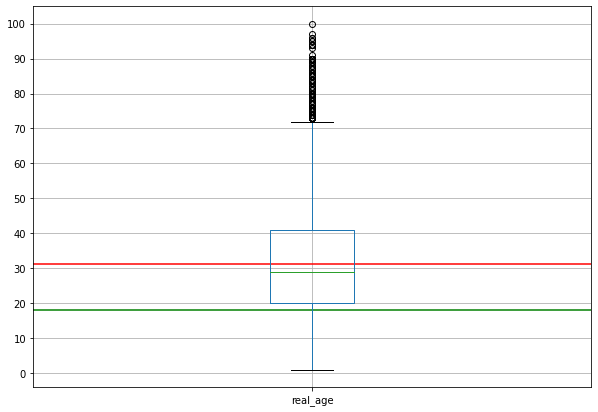

In [43]:
labels.boxplot(['real_age'],figsize=(10,7))
plt.yticks(np.arange(0, 101, 10))
# Promedio de edad
plt.hlines(labels['real_age'].mean(),xmin=0.5,xmax=1.5, colors='red')
# 18 años en verde
plt.hlines(18,xmin=0.5,xmax=1.5, colors='green')
plt.show()

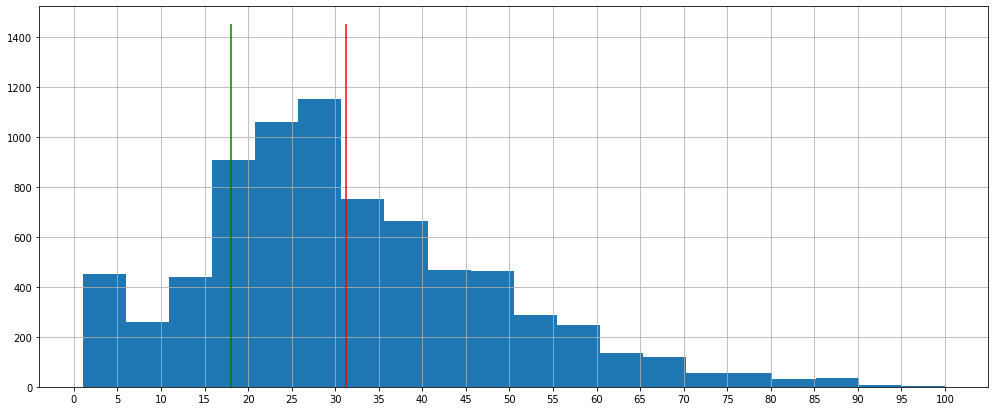

In [44]:
plt.figure(figsize=(17,7))
labels['real_age'].hist(bins=20)
plt.xticks(np.arange(0, 101, 5))
# Promedio en rojo
plt.vlines(labels['real_age'].mean(),ymin=0, ymax=1450, colors='red')
# 18 años en verde
plt.vlines(18,ymin=0, ymax=1450, colors='green')
plt.show()


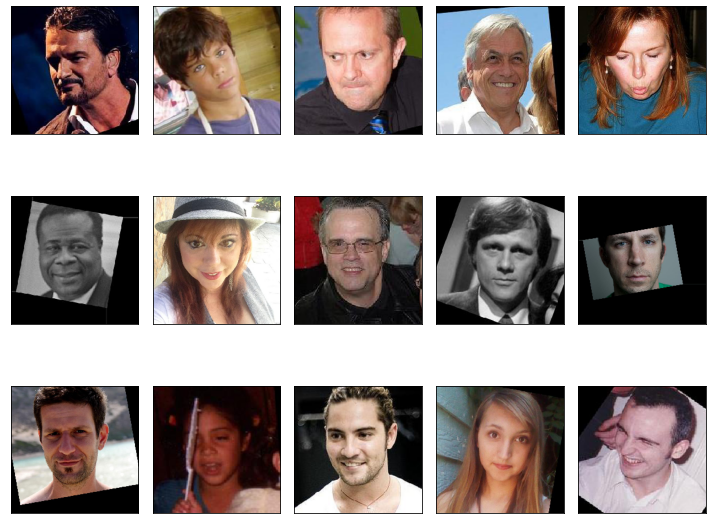

In [76]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
	# quita los ejes y coloca las imágenes cerca para obtener un output más compacto
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [70]:
target.min()

4

### Conclusiones

Tenemos una distribución de edades bastante pareja, con algunos valores altos extremos. Considerando que el punto de la predicción es considerar si una persona es mayor de edad para la venta legar de alcohol, se podría considerar crear una variable objetivo binaria. Este nuevo objativo se basaría en la pregunta "¿Puede esta persona comprar alcohol? Si o no.", esto podría ayudar al modelo a predecir de mejor manera. Se creara el posible objetivo, pero se continuará trabajando en la predicción de la edad como una regresión.

No se eliminaran los datos extremos, pues también debería ser parte del modelo poder predecir las edades de la tercera edad. Por el otro lado, tenemos a los jovenes que también resultan menos numerosos, de manera entendible pues estos comprarían con sus padres en la mayoría de los casos.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, AvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError

In [78]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.25)# width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, rotation_range=45)

    train_gen_flow  = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

    return train_gen_flow

In [79]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.25)

    test_gen_flow  = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 

    return test_gen_flow

In [87]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    loss=MeanAbsoluteError()
    metric='mae'
    optimizer = Adam(0.0001)
    
    backbone = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu'))

    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model

In [88]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    
    if validation_steps is None:
        validation_steps = len(test_data)
            
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True)

    return model


### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [1]:
init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, AvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError

import inspect

def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.25)# width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, rotation_range=45)

    train_gen_flow  = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
    # coloca tu código aquí

    return train_gen_flow

def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.25)

    test_gen_flow  = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    #  coloca tu código aquí

    return test_gen_flow

def create_model(input_shape):
    
    """
    Define el modelo
    """
    loss=MeanAbsoluteError()
    metric='mae'
    optimizer = Adam(0.0001)
    
    backbone = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu'))

    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True)

    return model


with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

60/60 - 9s - loss: 5.8838 - mae: 5.9112
Test MAE: 5.9112

## Conclusiones

¡Lo hemos logrado! Con la ayuda de una arquitectura tipo ResNet50 para identificar las imagenes hemos llegado a tener un EAM (MAE en inglés) menor a 6. Muy cercano al mínimo logrado por el equipo del paper presentado. 

Para esto hemos evitado alterar las fotos originales, utilizando la base (backbone) del modelo ResNet 50, activando la última capa con `relu` y optimizando con `Adam` utilizando una tasa de aprendizaje de 0.0001. Luego de estudiar los datos en la etapa de EDA, pudimos crear una red neuronal que se acomodara a los datos particulares de este proyecto.

Se estima que si se aumentara la cantidad de `epochs`, disminuyera la tasa de aprendizaje y aumentara el tiempo de trabajo en la GPU, se podría llegar a alcanzar aún mejores resultados.